In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import hdbscan
from spot import spot, tools

In [47]:
#SpotDisClust samples (optional!)

spike_times = np.load('./spot-main/example_data/spike_times_example.npy')
ii_spike_times = np.load('./spot-main/example_data/ii_spike_times_example.npy')
epoch_labels = np.load('./spot-main/example_data/epoch_labels_example.npy')

print('\nDemo data-set dimensions\n')
print('spike_times (#spikes): {}'.format(spike_times.shape))
print('ii_spike_times (#epochs x #neurons x 2): {}\n'.format(ii_spike_times.shape))


Demo data-set dimensions

spike_times (#spikes): (23769,)
ii_spike_times (#epochs x #neurons x 2): (180, 20, 2)



In [9]:
from scipy.io import loadmat
mat = loadmat('G:\\Sequences\\3_SleepPOST\\SleepPOST_all_data_new_CNMF.mat')

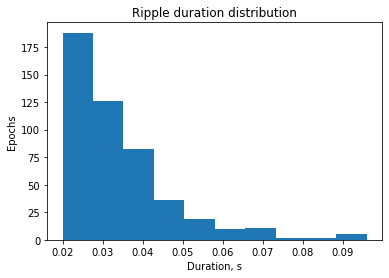

In [3]:
durs = [rip[2] - rip[0] for rip in mat['ripples']]
ax = plt.subplot()
ax.hist(durs)
ax.set_title('Ripple duration distribution')
ax.set_ylabel('Epochs')
ax.set_xlabel('Duration, s');

In [92]:
spike_times = []
ii_spike_times = []
duration = 0.2
fps = 100
duration_frames = int(duration*fps)
n_neurons = len(mat['EvtStarts'])
nbEvents = [] #number of events per epoch
minev = 10 #minimum number of events per epoch
nbEvents_valid =[] #number of events per valid epoch (i.e., passed by minev criterium)
cnt = 0 #counter of spikes

neurotime = mat['TTLstartsTimes']
#neurotime -= neurotime[0]

def time2ind(t):
    return np.where(neurotime >= t)[0][0]

for ripple in mat['ripples']:
    epoch = []
    ep_spike_times = []
    ep_start = time2ind(ripple[1]-duration/2)  #epoch start time in indices 
    rip_start = time2ind(ripple[0]) - ep_start #ripple start time in indicices (relative to the epoch start)
    rip_end = time2ind(ripple[2]) - ep_start   #ripple end time in indicices (relative to the epoch start)
    
    for neuron in mat['EvtStarts']:
        events = np.array(neuron[ep_start:ep_start + duration_frames])
        
        events[:rip_start] = 0 #drop all the events in the current epoch outside the current ripple
        events[rip_end:] = 0
        
        inds = np.nonzero(events)[0]/fps                #spike times and indices,
        ep_spike_times += inds.tolist()                 #realtive to the epoch start
        epoch.append([cnt, cnt+len(inds)])
        cnt += len(inds)
        
    if len(ep_spike_times) >= minev:
        spike_times += ep_spike_times
        ii_spike_times.append(epoch)
        nbEvents_valid.append(len(ep_spike_times))
    else:
        cnt -= len(ep_spike_times)
        
    nbEvents.append(len(ep_spike_times))
        
ii_spike_times = np.array(ii_spike_times)
print(f'Constructed {len(nbEvents_valid)} epochs from {len(nbEvents)} ripples\nFound {sum(nbEvents_valid)} events, av. {sum(nbEvents_valid)/len(nbEvents_valid):.1f} per epoch')

Constructed 310 epochs from 481 ripples
Found 7566 events, av. 24.4 per epoch


In [52]:
nbRipEpochs = len(nbEvents_valid)

In [15]:
#append another batch of randomized non-ripple epochs
ii_spike_times = ii_spike_times.tolist()       #conversion for proper addition
rand_inds = np.random.randint(low = 0, high = mat['EvtStarts'].shape[1] - duration_frames, size = 10*len(mat['ripples'])) #rnadom indices sequence

for rnd in rand_inds:
    epoch = []
    ep_spike_times = []
    for neuron in mat['EvtStarts']:
        events = np.array(neuron[rnd:rnd + duration_frames])
        inds = np.nonzero(events)[0]/fps                #spike times and indices,
        ep_spike_times += inds.tolist()                 #realtive to the epoch start
        epoch.append([cnt, cnt+len(inds)])
        cnt += len(inds)
    if len(ep_spike_times) >= minev:
        spike_times += ep_spike_times
        ii_spike_times.append(epoch)
        nbEvents_valid.append(len(ep_spike_times))
    else:
        cnt -= len(ep_spike_times)
        
    nbEvents.append(len(ep_spike_times))
ii_spike_times = np.array(ii_spike_times)
print(f'Constructed {len(nbEvents_valid)} epochs from {len(nbEvents)} ripples and random points\nFound {sum(nbEvents_valid)} events, av. {sum(nbEvents_valid)/len(nbEvents_valid):.1f} per epoch')

Constructed 1962 epochs from 5291 ripples and random points
Found 80314 events, av. 40.9 per epoch


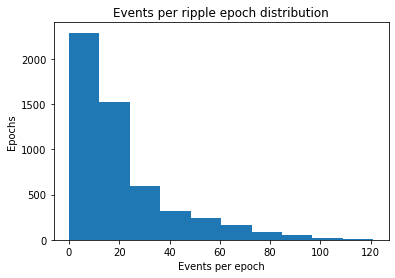

In [16]:
ax = plt.subplot()
ax.hist(nbEvents)
ax.set_title('Events per ripple epoch distribution')
ax.set_ylabel('Epochs')
ax.set_xlabel('Events per epoch');

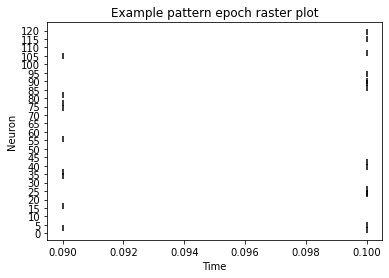

In [93]:
f, ax = plt.subplots()

ax.set_title('Example pattern epoch raster plot')

i_epoch = 23# np.argmax(epoch_labels == 1)
n_neurons = ii_spike_times.shape[1]

for i_neuron in range(n_neurons):
    tmp_epoch_neuron_spike_times = spike_times[ii_spike_times[i_epoch, i_neuron, 0]:ii_spike_times[i_epoch, i_neuron, 1]]
    ax.scatter(tmp_epoch_neuron_spike_times, np.ones(len(tmp_epoch_neuron_spike_times))+i_neuron, marker='|', c='black')

ax.set_yticks(np.arange(0, n_neurons+1, 5))
ax.set_ylabel('Neuron')
ax.set_xlabel('Time');

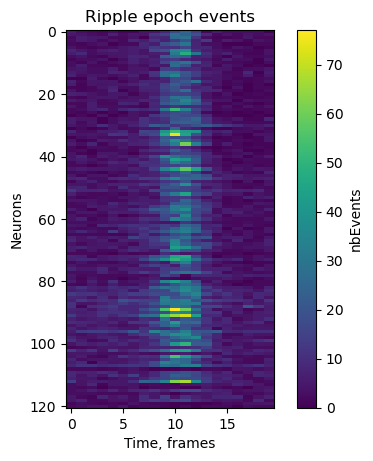

In [94]:
plt.figure(figsize = (6,5), dpi = 100)
ax = plt.subplot()
ax.set_title('Ripple epoch events')

events2d = np.zeros((n_neurons, duration_frames)) 
for ripple in mat['ripples']:
    rip_start = time2ind(ripple[1]-duration/2)
    pts = mat['EvtStarts'][:,rip_start:rip_start + duration_frames]
    if np.sum(pts) >=minev:
        events2d += pts 
plt.imshow(events2d, aspect = 0.3) 
plt.colorbar().set_label('nbEvents')
plt.xlabel('Time, frames')
plt.ylabel('Neurons');

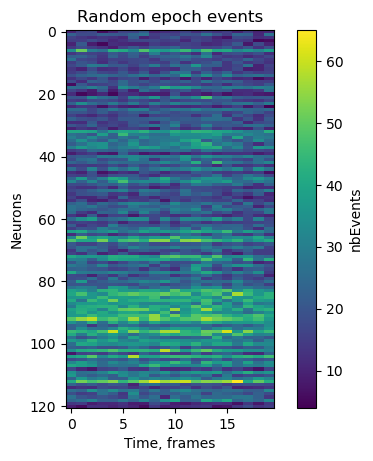

In [27]:
plt.figure(figsize = (6,5), dpi = 100)
ax = plt.subplot()
ax.set_title('Random epoch events')

events2d = np.zeros((n_neurons, duration_frames)) 
for rnd in rand_inds:
    pts = mat['EvtStarts'][:,rnd:rnd + duration_frames]
    if np.sum(pts) >= minev:
        events2d +=  pts
plt.imshow(events2d, aspect = 0.3) 
plt.colorbar().set_label('nbEvents')
plt.xlabel('Time, frames')
plt.ylabel('Neurons');

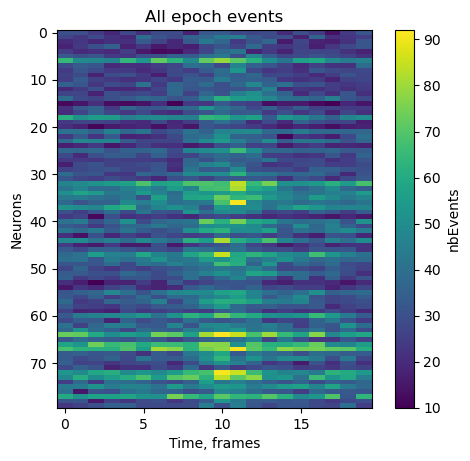

In [126]:
plt.figure(figsize = (6,5), dpi = 100)
ax = plt.subplot()

ax.set_title('All epoch events')
events2d = np.zeros((n_neurons, duration_frames))

for epoch in ii_spike_times:
    for i_neuron, neuron in enumerate(epoch):
        sp_indices = spike_times[neuron[0]:neuron[1]]
        for ind in sp_indices:
            events2d[i_neuron, int(ind*fps)] += 1

plt.imshow(events2d, aspect = 0.3) 
plt.colorbar().set_label('nbEvents')
plt.xlabel('Time, frames')
plt.ylabel('Neurons');

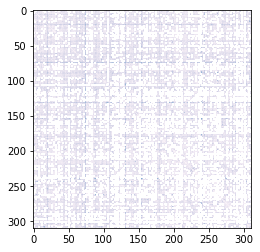

In [95]:
dissimilarities = spot.distances(spike_times, ii_spike_times, metric='SPOTD_xcorr')
plt.imshow(dissimilarities, cmap='PuBu')

In [102]:
clusterer = hdbscan.HDBSCAN(metric='precomputed')
cluster_labels = clusterer.fit_predict(np.nan_to_num(dissimilarities))
clusters = np.unique(cluster_labels)

print(len(clusters), 'clusters found')
for cl in clusters:
    print(f'Cluster # {cl} :{len(np.where(cluster_labels==cl)[0])} epochs') 
    

3 clusters found
Cluster # -1 :42 epochs
Cluster # 0 :101 epochs
Cluster # 1 :167 epochs


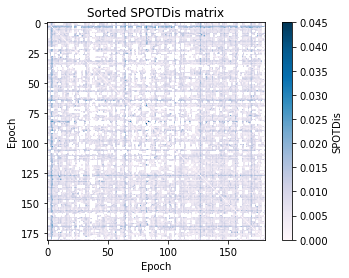

In [96]:
si = np.argsort(cluster_labels)
plt.title('Sorted SPOTDis matrix')
plt.imshow(dissimilarities[:, si][si], cmap='PuBu')
plt.colorbar().set_label('SPOTDis')
plt.xlabel('Epoch')
plt.ylabel('Epoch');

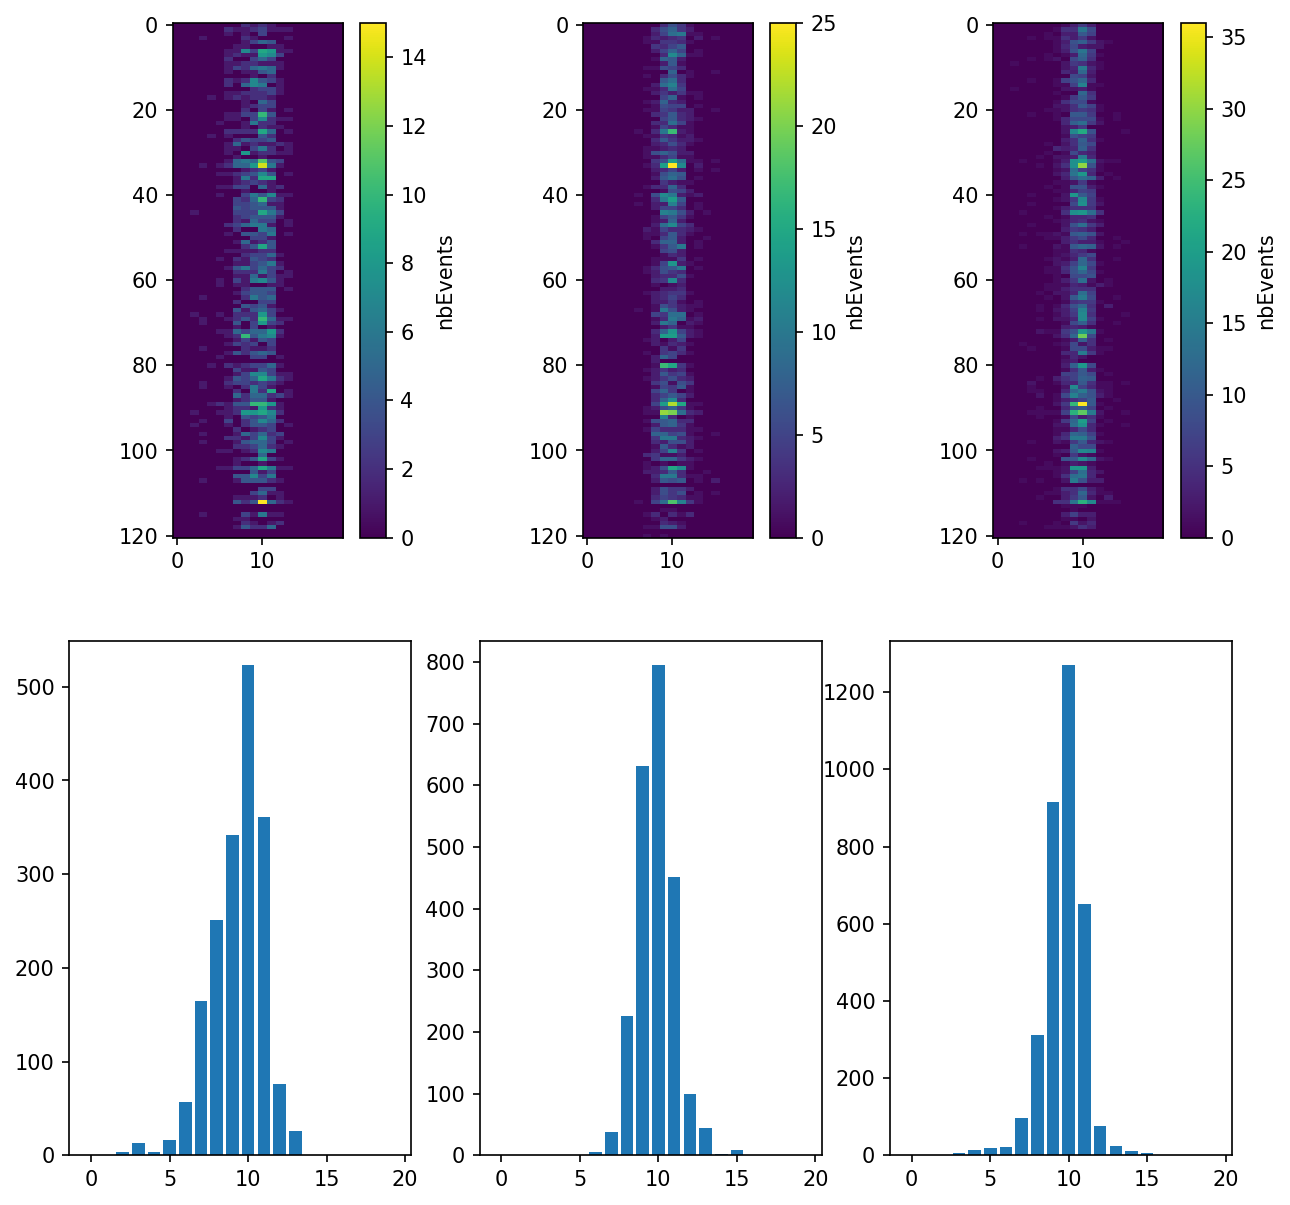

In [104]:
#show events distribution in clusters made of ripple and random epochs
cluster_event_sums = []    
n_clust = len(clusters)
figure, axes = plt.subplots(2,n_clust, figsize=(10, 10), dpi=150)
for icl, clust in enumerate(clusters):
    events2d = np.zeros((n_neurons, duration_frames))
    for nb_epoch in np.where(cluster_labels==clust)[0]:
        for i_neuron, neuron in enumerate(ii_spike_times[nb_epoch]):
            sp_indices = spike_times[neuron[0]:neuron[1]]
            for ind in sp_indices:
                events2d[i_neuron, int(ind*fps)] += 1
    plot = axes[0, icl].imshow(events2d, aspect = 0.5) 
    plt.colorbar(plot, ax=axes[0, icl]).set_label('nbEvents')
    axes[1, icl].bar(np.linspace(0,19,20), np.sum(events2d, axis = 0))
    cluster_event_sums.append(events2d)
    

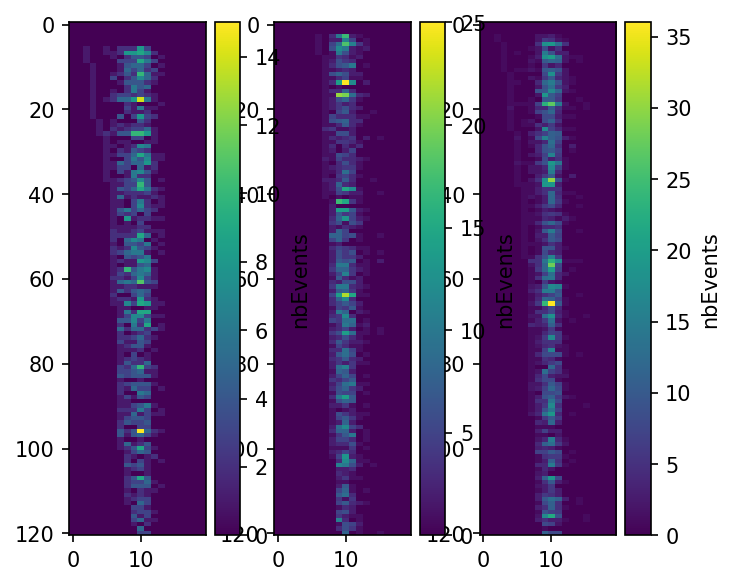

In [118]:
#show events distribution in clusters made of ripple and random epochs
figure, axes = plt.subplots(1,n_clust, figsize=(5, 10), dpi=150)
for icl, clust_sum in enumerate(cluster_event_sums):
    order = np.argsort(first_times)
    first_times = [0 if not np.count_nonzero(row) else np.nonzero(row)[0][0] for row in clust_sum]
    order = np.argsort(first_times)
    plot = axes[icl].imshow(clust_sum[order, :], aspect = 0.62) 
    plt.colorbar(plot, ax=axes[icl]).set_label('nbEvents')


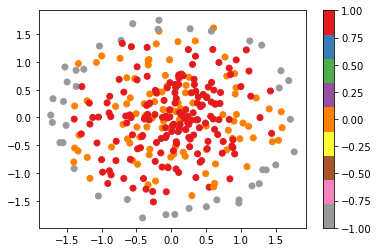

In [103]:
embedding = TSNE(metric='precomputed', n_components=2).fit_transform(np.nan_to_num(dissimilarities))
plt.scatter(embedding[:, 0], embedding[:, 1], cmap='Set1_r', c=cluster_labels)
plt.colorbar()

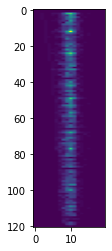

In [91]:
sum_events = np.sum(cluster_event_sums, axis = 0)
plt.imshow(sum_events[order,:], aspect = 0.5)

In [237]:
A = mat['ExtractedResults']['A'][0][0][:,5].todense()

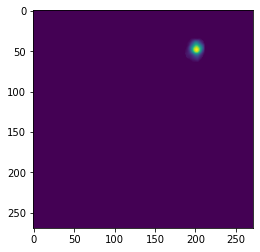

In [244]:
plt.imshow(A.reshape((269,272)))